In [104]:
import numpy as np

def chord_linear(y, b, c_root, c_tip):
    """Corda linear ao longo da envergadura."""
    return c_root + (c_tip - c_root) * (y / b)


def generate_structured_trapezoidal_mesh(
    b,
    c_root,
    c_tip,
    nx,   # divisões na corda
    ny    # divisões na meia-envergadura
):
    """
    Gera malha estruturada de trapézios para uma asa trapezoidal.

    Discretização:
        - ny divisões na meia-envergadura (0 → b)
        - nx divisões na corda local (0 → c(y))

    Retorna:
        nodes : array (N,3)
        quads : lista de [n1,n2,n3,n4]
        meta  : informações da malha
    """

    if b <= 0 or c_root <= 0 or c_tip <= 0:
        raise ValueError("b, c_root, c_tip devem ser > 0.")
    if nx <= 0 or ny <= 0:
        raise ValueError("nx e ny devem ser > 0.")

    # ---------- coordenadas em y ----------
    y_nodes = np.linspace(0.0, b, ny + 1)

    nodes = []
    node_id = {}

    def add_node(x, y, z=0.0):
        key = (round(float(x), 12), round(float(y), 12), round(float(z), 12))
        if key in node_id:
            return node_id[key]
        idx = len(nodes)
        nodes.append([x, y, z])
        node_id[key] = idx
        return idx

    # ---------- criar todos os nós ----------
    grid = []

    for j in range(ny + 1):
        y = y_nodes[j]
        c = chord_linear(y, b, c_root, c_tip)

        row = []
        for i in range(nx + 1):
            xi = i / nx
            x = xi * c
            row.append(add_node(x, y))
        grid.append(row)

    # ---------- criar elementos ----------
    quads = []

    for j in range(ny):
        for i in range(nx):
            n1 = grid[j][i]
            n2 = grid[j][i + 1]
            n3 = grid[j + 1][i + 1]
            n4 = grid[j + 1][i]

            quads.append([n1, n2, n3, n4])

    nodes = np.array(nodes, dtype=float)

    meta = {
        "nx": nx,
        "ny": ny,
        "y_nodes": y_nodes
    }

    return nodes, quads, meta

In [92]:
quads[0]

array([ 0,  1, 26, 27])

Número de nós: 625
Número de elementos (quads): 576


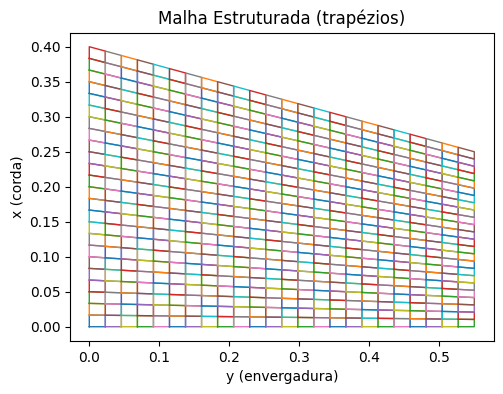

In [93]:
# ============================================================
# Célula 5 — Exemplo de uso + Plot
# ============================================================

import matplotlib.pyplot as plt

# ----- parâmetros da asa -----
b = .55       # meia-envergadura
c_root = 0.4    # corda na raiz
c_tip = 0.25    # corda na ponta

nx = 24          # divisões na corda
ny = 24        # divisões na envergadura

# ----- gerar malha -----
nodes, quads, meta = generate_structured_trapezoidal_mesh(
    b=b,
    c_root=c_root,
    c_tip=c_tip,
    nx=nx,
    ny=ny
)

print("Número de nós:", len(nodes))
print("Número de elementos (quads):", len(quads))


# ============================================================
# Plot 2D (mesma convenção que você usava)
# ============================================================

def plot_mesh_2d_structured(nodes, quads, title="Malha Estruturada (trapézios)"):

    plt.figure(figsize=(9,4))

    for q in quads:
        P = nodes[q][:, :2]
        P = np.vstack([P, P[0]])
        plt.plot(P[:,1], P[:,0], linewidth=1)  # y vira x, x vira y

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("y (envergadura)")
    plt.ylabel("x (corda)")
    plt.title(title)
    plt.show()


# ----- plotar -----
plot_mesh_2d_structured(nodes, quads)

In [96]:
nodes[quads[0]]

array([[0.        , 0.        , 0.        ],
       [0.01666667, 0.        , 0.        ],
       [0.01640625, 0.02291667, 0.        ],
       [0.        , 0.02291667, 0.        ]])

In [105]:
import numpy as np

def quad4_shape(xi, eta):
    """
    N (4,), dN_dxi (4,), dN_deta (4,) para QUAD4 bilinear
    Nós na ordem: (1) (-1,-1), (2) (1,-1), (3) (1,1), (4) (-1,1)
    """
    N = 0.25 * np.array([
        (1 - xi) * (1 - eta),
        (1 + xi) * (1 - eta),
        (1 + xi) * (1 + eta),
        (1 - xi) * (1 + eta)
    ], dtype=float)

    dN_dxi = 0.25 * np.array([
        -(1 - eta),
        +(1 - eta),
        +(1 + eta),
        -(1 + eta)
    ], dtype=float)

    dN_deta = 0.25 * np.array([
        -(1 - xi),
        -(1 + xi),
        +(1 + xi),
        +(1 - xi)
    ], dtype=float)

    return N, dN_dxi, dN_deta


def quad4_mindlin_element_matrices(xy, E, nu, h, rho, kappa=5/6):
    """
    Mindlin-Reissner QUAD4 com DOFs por nó: [w, tx, ty].
    Retorna Ke, Me (12x12).

    xy: array (4,2) com os nós do elemento na ordem QUAD4:
        1:(-1,-1), 2:(+1,-1), 3:(+1,+1), 4:(-1,+1) no espaço paramétrico.
    """
    # matrizes constitutivas
    D = E * h**3 / (12 * (1 - nu**2))
    Db = D * np.array([[1,   nu, 0],
                       [nu,  1,  0],
                       [0,   0, (1-nu)/2]], dtype=float)

    G = E / (2 * (1 + nu))
    Ds = (kappa * G * h) * np.eye(2)

    Ke = np.zeros((12, 12), dtype=float)
    Me = np.zeros((12, 12), dtype=float)

    # ---- Gauss 2x2 para bending e massa ----
    gp = 1.0 / np.sqrt(3.0)
    gauss_2x2 = [(-gp, -gp, 1.0), ( gp, -gp, 1.0),
                ( gp,  gp, 1.0), (-gp,  gp, 1.0)]

    # massa por área
    mw = rho * h
    mr = rho * (h**3) / 12.0

    for xi, eta, wgt in gauss_2x2:
        N, dN_dxi, dN_deta = quad4_shape(xi, eta)

        # Jacobiano
        J = np.zeros((2, 2), dtype=float)
        J[0, 0] = np.dot(dN_dxi,  xy[:, 0])   # dx/dxi
        J[0, 1] = np.dot(dN_deta, xy[:, 0])   # dx/deta
        J[1, 0] = np.dot(dN_dxi,  xy[:, 1])   # dy/dxi
        J[1, 1] = np.dot(dN_deta, xy[:, 1])   # dy/deta

        detJ = np.linalg.det(J)
        if detJ <= 0:
            raise ValueError("Elemento QUAD com det(J) <= 0 (ordem dos nós / elemento invertido).")

        invJ = np.linalg.inv(J)

        # derivadas em x,y
        dN_dx = invJ[0, 0] * dN_dxi + invJ[0, 1] * dN_deta
        dN_dy = invJ[1, 0] * dN_dxi + invJ[1, 1] * dN_deta

        # ---- bending B (3 x 12) ----
        # kx = dtx/dx
        # ky = dty/dy
        # kxy = dtx/dy + dty/dx
        Bb = np.zeros((3, 12), dtype=float)

        for i in range(4):
            wi  = 3*i
            txi = 3*i + 1
            tyi = 3*i + 2

            Bb[0, txi] = dN_dx[i]
            Bb[1, tyi] = dN_dy[i]
            Bb[2, txi] = dN_dy[i]
            Bb[2, tyi] = dN_dx[i]

        Ke += (Bb.T @ Db @ Bb) * detJ * wgt

        # ---- massa consistente (para w, tx, ty) ----
        # Integra N^T N dA via 2x2
        NN = np.outer(N, N)  # (4x4)
        dA = detJ * wgt

        for a in range(4):
            for b in range(4):
                Me[3*a,   3*b]   += mw * NN[a, b] * dA
                Me[3*a+1, 3*b+1] += mr * NN[a, b] * dA
                Me[3*a+2, 3*b+2] += mr * NN[a, b] * dA

    # ---- Gauss 1x1 para shear (reduz locking) ----
    xi = 0.0
    eta = 0.0
    wgt = 4.0  # peso do 1x1 em [-1,1]^2

    N, dN_dxi, dN_deta = quad4_shape(xi, eta)

    J = np.zeros((2, 2), dtype=float)
    J[0, 0] = np.dot(dN_dxi,  xy[:, 0])
    J[0, 1] = np.dot(dN_deta, xy[:, 0])
    J[1, 0] = np.dot(dN_dxi,  xy[:, 1])
    J[1, 1] = np.dot(dN_deta, xy[:, 1])

    detJ = np.linalg.det(J)
    if detJ <= 0:
        raise ValueError("Elemento QUAD com det(J) <= 0 no ponto central (elemento ruim/invertido).")

    invJ = np.linalg.inv(J)
    dN_dx = invJ[0, 0] * dN_dxi + invJ[0, 1] * dN_deta
    dN_dy = invJ[1, 0] * dN_dxi + invJ[1, 1] * dN_deta

    # shear strains:
    # gx = tx + dw/dx
    # gy = ty + dw/dy
    Bs = np.zeros((2, 12), dtype=float)
    for i in range(4):
        wi  = 3*i
        txi = 3*i + 1
        tyi = 3*i + 2

        Bs[0, wi]  = dN_dx[i]
        Bs[0, txi] = N[i]

        Bs[1, wi]  = dN_dy[i]
        Bs[1, tyi] = N[i]

    Ke += (Bs.T @ Ds @ Bs) * detJ * wgt

    return Ke, Me

In [106]:
from scipy.sparse import lil_matrix

def assemble_KM_mindlin_quad4(nodes, quads, E, nu, h, rho, kappa=5/6):
    """
    Monta K e M globais para Mindlin QUAD4.
    DOFs por nó: [w, tx, ty] => 3*n_nodes DOFs.
    """
    n_nodes = nodes.shape[0]
    ndof = 3 * n_nodes

    K = lil_matrix((ndof, ndof), dtype=float)
    M = lil_matrix((ndof, ndof), dtype=float)

    for q in quads:
        q = np.array(q, dtype=int)
        xy = nodes[q, :2]  # (4,2)

        Ke, Me = quad4_mindlin_element_matrices(xy, E=E, nu=nu, h=h, rho=rho, kappa=kappa)

        dofs = []
        for nid in q:
            dofs.extend([3*nid, 3*nid+1, 3*nid+2])
        dofs = np.array(dofs, dtype=int)  # (12,)

        # assemble
        for a in range(12):
            ia = dofs[a]
            for b in range(12):
                ib = dofs[b]
                K[ia, ib] += Ke[a, b]
                M[ia, ib] += Me[a, b]

    return K.tocsc(), M.tocsc()

In [107]:
import numpy as np

def apply_clamped_root_bc_mindlin(nodes, K, M, y_root=0.0, tol=1e-12):
    """
    Engaste na raiz: y == y_root => w=tx=ty=0.
    Retorna Kff, Mff, free, fixed, root_nodes.
    """
    y = nodes[:, 1]
    root_nodes = np.where(np.isclose(y, y_root, atol=tol))[0]

    fixed = []
    for nid in root_nodes:
        fixed.extend([3*nid, 3*nid+1, 3*nid+2])
    fixed = np.array(sorted(set(fixed)), dtype=int)

    ndof = K.shape[0]
    all_dofs = np.arange(ndof, dtype=int)
    free = np.setdiff1d(all_dofs, fixed)

    Kff = K[free][:, free]
    Mff = M[free][:, free]
    return Kff, Mff, free, fixed, root_nodes

In [109]:
from scipy.sparse.linalg import eigsh
import numpy as np

def solve_modes(Kff, Mff, n_modes=6, sigma=0.0):
    vals, vecs = eigsh(Kff, k=n_modes, M=Mff, sigma=sigma, which='LM')
    vals = np.real(vals)
    vecs = np.real(vecs)
    idx = np.argsort(vals)
    vals = vals[idx]
    vecs = vecs[:, idx]
    omega = np.sqrt(np.clip(vals, 0, None))
    return omega, vecs


# -----------------------------
# Parâmetros
# -----------------------------
E = 70e9
nu = 0.33
rho = 2700
h_plate = 0.005

# -----------------------------
# Montagem K e M (QUAD4 direto)
# -----------------------------
K, M = assemble_KM_mindlin_quad4(nodes, quads, E=E, nu=nu, h=h_plate, rho=rho)

# Engaste na raiz
Kff, Mff, free, fixed, root_nodes = apply_clamped_root_bc_mindlin(nodes, K, M, y_root=0.0, tol=1e-10)

print(f"DOFs totais: {K.shape[0]} | DOFs fixos: {len(fixed)} | DOFs livres: {len(free)}")
print(f"Nós na raiz: {len(root_nodes)}")

# Modos
n_modes = 4
omega, vecs = solve_modes(Kff, Mff, n_modes=n_modes, sigma=0.0)
freq_hz = omega / (2*np.pi)

print("\nFrequências naturais (Hz):")
for i, f in enumerate(freq_hz, start=1):
    print(f"  modo {i}: {f:.4f} Hz")

DOFs totais: 1875 | DOFs fixos: 75 | DOFs livres: 1800
Nós na raiz: 25

Frequências naturais (Hz):
  modo 1: 16.5105 Hz
  modo 2: 59.0850 Hz
  modo 3: 93.9539 Hz
  modo 4: 181.2152 Hz


In [25]:
import numpy as np

def tri_area2(xy):
    (x1,y1),(x2,y2),(x3,y3) = xy
    return (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)

def quads_to_tris_consistent(nodes, quads):
    """Split dos quads em 2 tris com orientação consistente (área positiva)."""
    tris = []
    for (n1,n2,n3,n4) in quads:
        t1 = [n1, n2, n3]
        t2 = [n1, n3, n4]

        if tri_area2(nodes[np.array(t1), :2]) < 0:
            t1 = [n1, n3, n2]
        if tri_area2(nodes[np.array(t2), :2]) < 0:
            t2 = [n1, n4, n3]

        tris.append(t1)
        tris.append(t2)
    return np.array(tris, dtype=int)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.tri import Triangulation
from matplotlib.colors import LinearSegmentedColormap, Normalize

def save_mode_gif_3d(nodes, tris, w, filename,
                     freq_hz=None, amp=0.1, n_frames=60, fps=24,
                     elev=25, azim=-60):
    """
    GIF 3D (trisurf) do modo.
    Cores baseadas em |z| (verde em 0, vermelho escuro no máximo).
    """

    x = nodes[:, 0]
    y = nodes[:, 1]
    tris = np.asarray(tris, dtype=int)
    tri = Triangulation(x, y, tris)

    # modo normalizado
    w = np.asarray(w, dtype=float)
    w = w / (np.max(np.abs(w)) + 1e-12)

    norm = Normalize(vmin=0.0, vmax=amp)
    cmap = LinearSegmentedColormap.from_list("green_to_darkred", ["#00aa00", "#7a0000"])

    fig = plt.figure(figsize=(7.5, 6.0))
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    title = "Modo (3D)"
    if freq_hz is not None:
        title += f" — f = {freq_hz:.3f} Hz"
    ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("w (visual)")
    ax.view_init(elev=elev, azim=azim)
    ax.set_zlim(-amp, amp)

    # frame inicial
    phase0 = 0.0
    z0 = amp * np.sin(phase0) * w
    c0_tri = np.abs(z0)[tris].mean(axis=1)

    surf = ax.plot_trisurf(tri, z0, linewidth=0.2, antialiased=True,
                           cmap=cmap, norm=norm, shade=False)
    surf.set_array(c0_tri)
    surf.set_clim(0.0, amp)

    # colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.75, pad=0.05)
    cbar.set_label("|w| (deformação visual)")

    def update(frame):
        nonlocal surf
        phase = 2 * np.pi * frame / (n_frames - 1)
        z = amp * np.sin(phase) * w
        c_tri = np.abs(z)[tris].mean(axis=1)

        surf.remove()
        surf = ax.plot_trisurf(tri, z, linewidth=0.2, antialiased=True,
                               cmap=cmap, norm=norm, shade=False)
        surf.set_array(c_tri)
        surf.set_clim(0.0, amp)
        return (surf,)

    ani = animation.FuncAnimation(fig, update, frames=n_frames,
                                  interval=1000 / fps, blit=False)

    ani.save(filename, writer=animation.PillowWriter(fps=fps))
    plt.close(fig)
    print(f"GIF 3D salvo em: {filename}")

In [27]:
def save_first_4_modes_gifs_3d(nodes, quads_or_tris, vecs, free, ndof_total,
                              freq_hz=None, prefix="modo",
                              amp=0.1, n_frames=60, fps=24,
                              elev=25, azim=-60, is_quads=True):
    """
    Salva GIFs 3D para modos 1..4.
    - se is_quads=True, converte quads->tris para plot.
    - vecs: matriz (ndof_livres, n_modes)
    - free: índices dos DOFs livres
    - ndof_total: total de DOFs (3*n_nodes)
    """

    if is_quads:
        tris_plot = quads_to_tris_consistent(nodes, quads_or_tris)
    else:
        tris_plot = np.asarray(quads_or_tris, dtype=int)

    n_modes_available = vecs.shape[1]
    n_to_save = min(4, n_modes_available)

    for m in range(n_to_save):
        full = np.zeros(ndof_total, dtype=float)
        full[free] = vecs[:, m]

        w = full[0::3]  # pega w em cada nó
        w = w / (np.max(np.abs(w)) + 1e-12)

        f = None
        if freq_hz is not None:
            f = float(freq_hz[m])

        filename = f"{prefix}_modo{m+1:02d}_3d.gif"
        save_mode_gif_3d(nodes, tris_plot, w, filename,
                         freq_hz=f, amp=amp, n_frames=n_frames, fps=fps,
                         elev=elev, azim=azim)

In [28]:
# ndof_total = 3 * nodes.shape[0]
ndof_total = 3 * nodes.shape[0]

# Se você tem quads (malha estruturada):
save_first_4_modes_gifs_3d(
    nodes=nodes,
    quads_or_tris=quads,     # <- seus trapézios
    vecs=vecs,
    free=free,
    ndof_total=ndof_total,
    freq_hz=freq_hz,
    prefix="asa",
    amp=0.15,
    n_frames=80,
    fps=24,
    elev=25,
    azim=-60,
    is_quads=True
)

GIF 3D salvo em: asa_modo01_3d.gif
GIF 3D salvo em: asa_modo02_3d.gif
GIF 3D salvo em: asa_modo03_3d.gif
GIF 3D salvo em: asa_modo04_3d.gif


In [29]:
import numpy as np
from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import splu

def newmark_impulse_response(K, M, dof_in, dof_out,
                             dt=1e-4, t_end=1.0,
                             alpha=0.0, beta_rayleigh=0.0,
                             impulse_Ns=1.0,
                             gamma=0.5, beta_newmark=0.25):
    """
    Resposta ao impulso entre DOFs:
      - impulso (N*s) aplicado em dof_in no instante t=0
      - retorna deslocamento no dof_out ao longo do tempo

    Implementação:
      q0 = 0
      v0 = M^{-1} p  (p[dof_in] = impulse_Ns)
      força externa f(t)=0 para t>0

    Amortecimento Rayleigh: C = alpha*M + beta_rayleigh*K
    """

    if not isinstance(K, csc_matrix):
        K = csc_matrix(K)
    if not isinstance(M, csc_matrix):
        M = csc_matrix(M)

    n = K.shape[0]
    n_steps = int(np.floor(t_end / dt)) + 1
    t = np.linspace(0.0, dt*(n_steps-1), n_steps)

    # C = aM + bK
    C = alpha * M + beta_rayleigh * K

    # Condições iniciais
    q = np.zeros(n)
    a = np.zeros(n)

    p = np.zeros(n)
    p[dof_in] = impulse_Ns

    # v0 = M^{-1} p
    luM = splu(M)  # fatoração para resolver rápido
    v = luM.solve(p)

    # Newmark constantes
    b = beta_newmark
    g = gamma

    a0 = 1.0 / (b * dt * dt)
    a1 = g / (b * dt)
    a2 = 1.0 / (b * dt)
    a3 = 1.0 / (2*b) - 1.0
    a4 = g / b - 1.0
    a5 = dt * (g / (2*b) - 1.0)

    # Matriz efetiva
    Keff = K + a1 * C + a0 * M
    luK = splu(Keff)

    # armazenamento de saída
    y = np.zeros(n_steps)
    y[0] = q[dof_out]

    # força externa pós-impulso (zero)
    f = np.zeros(n)

    for k in range(1, n_steps):
        # RHS efetivo
        rhs = (f
               + M.dot(a0*q + a2*v + a3*a)
               + C.dot(a1*q + a4*v + a5*a))

        q_new = luK.solve(rhs)

        a_new = a0*(q_new - q) - a2*v - a3*a
        v_new = v + dt*((1-g)*a + g*a_new)

        q, v, a = q_new, v_new, a_new
        y[k] = q[dof_out]

    return t, y

In [30]:
def map_full_dof_to_free_index(free, dof_full):
    """
    Retorna o índice i tal que free[i] == dof_full.
    Erro se dof_full estiver fixo.
    """
    pos = np.searchsorted(free, dof_full)
    if pos >= len(free) or free[pos] != dof_full:
        raise ValueError("DOF escolhido não está livre (provavelmente está fixo na BC).")
    return int(pos)

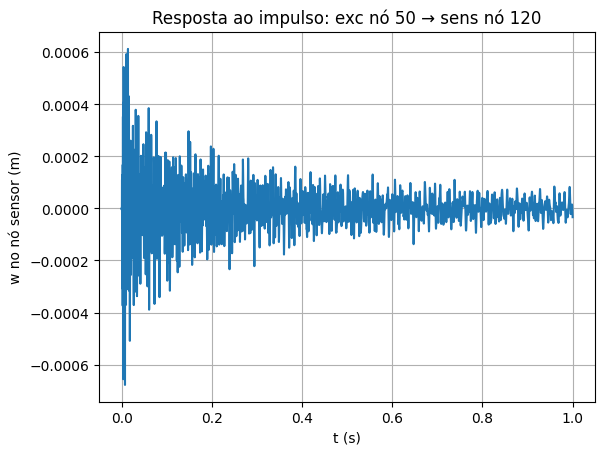

In [33]:
# escolha nós (exemplo)
node_exc = 50     # nó onde aplica impulso
node_sense = 120  # nó onde mede resposta

# DOFs (no sistema completo)
dof_in_full  = 3*node_exc        # w
dof_out_full = 3*node_sense      # w

# mapear para sistema reduzido (livre)
dof_in  = map_full_dof_to_free_index(free, dof_in_full)
dof_out = map_full_dof_to_free_index(free, dof_out_full)

# parâmetros de tempo
dt = 1e-4
t_end = 1.0

# amortecimento Rayleigh (valores iniciais razoáveis pra teste)
alpha = 0.5      # ajuste depois
beta_ray = 1e-6  # ajuste depois

t, y = newmark_impulse_response(
    Kff, Mff,
    dof_in=dof_in,
    dof_out=dof_out,
    dt=dt, t_end=t_end,
    alpha=alpha, beta_rayleigh=beta_ray,
    impulse_Ns=1.0,   # impulso unitário (N*s)
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, y)
plt.xlabel("t (s)")
plt.ylabel("w no nó sensor (m)")
plt.title(f"Resposta ao impulso: exc nó {node_exc} → sens nó {node_sense}")
plt.grid(True)
plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

def map_full_dof_to_free_index(free, dof_full):
    pos = np.searchsorted(free, dof_full)
    if pos >= len(free) or free[pos] != dof_full:
        raise ValueError("DOF escolhido não está livre (provavelmente fixo pela BC).")
    return int(pos)

def compute_modes_mass_normalized(Kff, Mff, n_modes=30, sigma=0.0):
    """
    Resolve K φ = λ M φ, retorna:
      omega (rad/s), Phi (mass-normalizada: Phi^T M Phi = I)
    """
    vals, vecs = eigsh(Kff, k=n_modes, M=Mff, sigma=sigma, which="LM")
    vals = np.real(vals)
    vecs = np.real(vecs)

    idx = np.argsort(vals)
    vals = vals[idx]
    vecs = vecs[:, idx]

    omega = np.sqrt(np.clip(vals, 0, None))  # rad/s

    # mass-normalização
    Phi = vecs.copy()
    for r in range(Phi.shape[1]):
        mr = Phi[:, r].T @ (Mff @ Phi[:, r])
        Phi[:, r] /= np.sqrt(mr + 1e-30)

    return omega, Phi

def frf_modal_receptance(omega_modes, Phi, dof_in, dof_out, freqs_hz, zeta=0.01):
    """
    FRF receptance H = x_out / F_in (m/N) via soma modal.
    dof_in/dof_out são índices no sistema reduzido (livre).
    """
    w = 2*np.pi*np.asarray(freqs_hz, dtype=float)  # rad/s
    H = np.zeros_like(w, dtype=np.complex128)

    phi_in = Phi[dof_in, :]   # (n_modes,)
    phi_out = Phi[dof_out, :] # (n_modes,)

    for r in range(len(omega_modes)):
        wr = omega_modes[r]
        num = phi_out[r] * phi_in[r]
        den = (wr**2 - w**2) + 1j*(2*zeta*wr*w)
        H += num / den

    return H  # complexo

def plot_frf(freqs_hz, H, title="FRF |H(f)|"):
    plt.figure()
    plt.plot(freqs_hz, np.abs(H))
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("|H(f)| (m/N)  [receptância]")
    plt.title(title)
    plt.grid(True)
    plt.show()

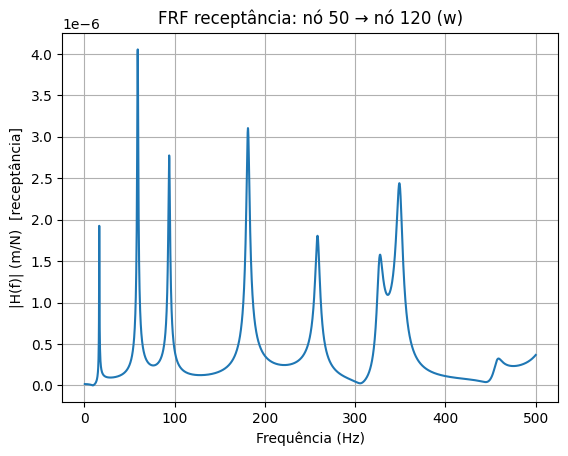

In [35]:
# escolha nós (exemplo)
node_exc   = 50
node_sense = 120

# DOF full (w)
dof_in_full  = 3*node_exc
dof_out_full = 3*node_sense

# mapear para reduzido (livre)
dof_in  = map_full_dof_to_free_index(free, dof_in_full)
dof_out = map_full_dof_to_free_index(free, dof_out_full)

# modos pra FRF (ajuste conforme necessário)
n_modes = 40
omega_modes, Phi = compute_modes_mass_normalized(Kff, Mff, n_modes=n_modes, sigma=0.0)

# faixa de frequência
fmax = 500.0
freqs = np.linspace(0.5, fmax, 3000)  # evita 0 pra não dar divisão feia

# amortecimento modal (ex.: 1%)
zeta = 0.01

H = frf_modal_receptance(omega_modes, Phi, dof_in, dof_out, freqs, zeta=zeta)

plot_frf(freqs, H, title=f"FRF receptância: nó {node_exc} → nó {node_sense} (w)")

In [37]:
import numpy as np

def find_nearest_node(nodes, x_target, y_target, use_xy_cols=(0,1)):
    """
    Retorna (nid, dist, (x_n, y_n)) do nó mais próximo de (x_target, y_target).
    nodes: array (N,3) ou (N,2)
    use_xy_cols: quais colunas são x e y (default (0,1))
    """
    x = nodes[:, use_xy_cols[0]]
    y = nodes[:, use_xy_cols[1]]

    dx = x - float(x_target)
    dy = y - float(y_target)
    d2 = dx*dx + dy*dy

    nid = int(np.argmin(d2))
    dist = float(np.sqrt(d2[nid]))
    return nid, dist, (float(x[nid]), float(y[nid]))


def nearest_node_report(nodes, x_target, y_target, label=""):
    nid, dist, (xn, yn) = find_nearest_node(nodes, x_target, y_target)
    msg = f"{label} alvo=({x_target:.6g},{y_target:.6g}) -> nó {nid} em ({xn:.6g},{yn:.6g}), dist={dist:.6g}"
    return nid, msg

In [38]:
def node_to_dof(nid, dof_type="w"):
    """
    dof_type: 'w', 'tx', 'ty'
    """
    if dof_type == "w":
        return 3*nid
    if dof_type == "tx":
        return 3*nid + 1
    if dof_type == "ty":
        return 3*nid + 2
    raise ValueError("dof_type deve ser 'w', 'tx' ou 'ty'.")

def map_full_dof_to_free_index(free, dof_full):
    """
    Retorna i tal que free[i] == dof_full (sistema reduzido).
    """
    free = np.asarray(free, dtype=int)
    pos = np.searchsorted(free, dof_full)
    if pos >= len(free) or free[pos] != dof_full:
        raise ValueError("DOF escolhido não está livre (está fixo pela BC ou não existe).")
    return int(pos)

In [39]:
def pick_dofs_by_coordinates(nodes, free,
                            x_exc, y_exc, x_sense, y_sense,
                            dof_in_type="w", dof_out_type="w"):
    """
    Escolhe nós mais próximos de duas coordenadas:
      - (x_exc,y_exc): excitação
      - (x_sense,y_sense): medição

    Retorna:
      info (dict) com nós, distâncias, coords escolhidas
      dof_in_free, dof_out_free (índices no sistema reduzido)
    """
    nid_in, msg_in = nearest_node_report(nodes, x_exc, y_exc, label="Excitação")
    nid_out, msg_out = nearest_node_report(nodes, x_sense, y_sense, label="Medição ")

    dof_in_full  = node_to_dof(nid_in,  dof_in_type)
    dof_out_full = node_to_dof(nid_out, dof_out_type)

    dof_in_free  = map_full_dof_to_free_index(free, dof_in_full)
    dof_out_free = map_full_dof_to_free_index(free, dof_out_full)

    info = {
        "excitation": {"target": (x_exc, y_exc), "node": nid_in,  "dof_type": dof_in_type,  "dof_full": dof_in_full},
        "sensing":    {"target": (x_sense, y_sense), "node": nid_out, "dof_type": dof_out_type, "dof_full": dof_out_full},
        "messages": (msg_in, msg_out),
    }
    return info, dof_in_free, dof_out_free

Excitação alvo=(0.8,0.2) -> nó 124 em (0.375,0.0916667), dist=0.43859
Medição  alvo=(1.2,6) -> nó 624 em (0.25,0.55), dist=5.53218
DOF livre (entrada): 297 | DOF livre (saída): 1797


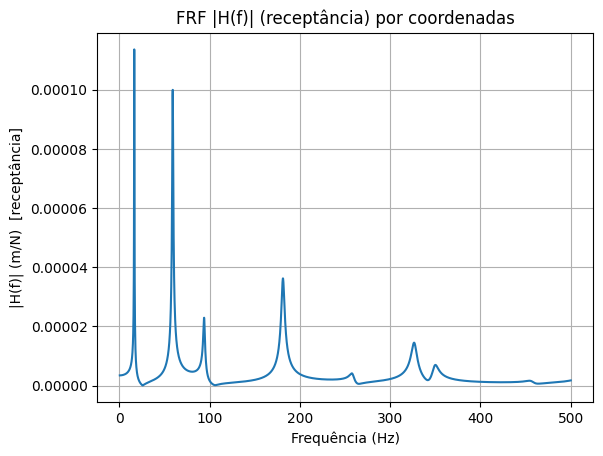

In [40]:
# coordenadas (exemplo)
x_exc, y_exc = 0.8, 0.2     # aplica força aqui (m)
x_sen, y_sen = 1.2, 6.0     # mede aqui (m)

info, dof_in, dof_out = pick_dofs_by_coordinates(
    nodes, free,
    x_exc=x_exc, y_exc=y_exc,
    x_sense=x_sen, y_sense=y_sen,
    dof_in_type="w", dof_out_type="w"
)

print(info["messages"][0])
print(info["messages"][1])
print("DOF livre (entrada):", dof_in, "| DOF livre (saída):", dof_out)

# modos
omega_modes, Phi = compute_modes_mass_normalized(Kff, Mff, n_modes=40, sigma=0.0)

# FRF
freqs = np.linspace(0.5, 500.0, 3000)
H = frf_modal_receptance(omega_modes, Phi, dof_in, dof_out, freqs_hz=freqs, zeta=0.01)

plot_frf(freqs, H, title="FRF |H(f)| (receptância) por coordenadas")

In [41]:
import numpy as np
from scipy.signal import find_peaks

def find_frf_peaks(freqs_hz, H=None, amp=None,
                   prominence_ratio=0.05,
                   min_distance_hz=1.0,
                   max_peaks=10):
    """
    Encontra picos em uma curva de FRF.

    Entrada:
      - freqs_hz: array (N,)
      - H: FRF complexa (N,)  -> usa amp = |H|
      - amp: amplitude já pronta (N,) (se quiser passar direto)

    Parâmetros:
      - prominence_ratio: fração do (max-min) da curva usada como prominence mínima
      - min_distance_hz: distância mínima entre picos (Hz)
      - max_peaks: retorna no máximo isso (maiores amplitudes)

    Retorna:
      peaks: lista de dicts com {idx, freq_hz, amp, prominence}
      idxs: índices dos picos
    """
    f = np.asarray(freqs_hz, dtype=float)

    if amp is None:
        if H is None:
            raise ValueError("Passe H (complexo) ou amp (amplitude).")
        a = np.abs(np.asarray(H))
    else:
        a = np.asarray(amp, dtype=float)

    if len(f) != len(a):
        raise ValueError("freqs_hz e amp/H precisam ter o mesmo tamanho.")

    # passo de frequência (assumindo quase uniforme)
    df = float(np.median(np.diff(f)))
    if df <= 0:
        raise ValueError("freqs_hz precisa ser crescente.")

    # prominence mínima baseada na escala da curva
    a_min = float(np.min(a))
    a_max = float(np.max(a))
    prom_min = prominence_ratio * (a_max - a_min)

    # distância mínima em amostras
    dist_samples = max(1, int(np.round(min_distance_hz / df)))

    idxs, props = find_peaks(a, prominence=prom_min, distance=dist_samples)

    # monta lista
    peaks = []
    for k, idx in enumerate(idxs):
        peaks.append({
            "idx": int(idx),
            "freq_hz": float(f[idx]),
            "amp": float(a[idx]),
            "prominence": float(props["prominences"][k]),
        })

    # ordenar por amplitude (desc)
    peaks.sort(key=lambda d: d["amp"], reverse=True)

    # limitar
    peaks = peaks[:max_peaks]
    idxs_sorted = np.array([p["idx"] for p in peaks], dtype=int)

    return peaks, idxs_sorted

In [42]:
# supondo que você já tem:
# freqs (Hz) e H (complexo)
amp = np.abs(H)

peaks, peak_idxs = find_frf_peaks(
    freqs_hz=freqs,
    amp=amp,
    prominence_ratio=0.05,   # ajuste: 0.02 mais sensível / 0.1 mais rígido
    min_distance_hz=2.0,     # ajuste conforme sua resolução df
    max_peaks=8
)

print("Picos encontrados (ordenados por amplitude):")
for i, p in enumerate(peaks, start=1):
    print(f"{i:02d}) f = {p['freq_hz']:.3f} Hz | |H| = {p['amp']:.4e} | prom = {p['prominence']:.4e}")

Picos encontrados (ordenados por amplitude):
01) f = 16.489 Hz | |H| = 1.1360e-04 | prom = 1.1016e-04
02) f = 59.128 Hz | |H| = 9.9934e-05 | prom = 9.9795e-05
03) f = 181.213 Hz | |H| = 3.6237e-05 | prom = 3.5651e-05
04) f = 93.938 Hz | |H| = 2.2922e-05 | prom = 1.8236e-05
05) f = 326.449 Hz | |H| = 1.4507e-05 | prom = 1.3859e-05


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(freqs, amp, label="|H(f)|")
plt.plot(freqs[peak_idxs], amp[peak_idxs], "o", label="picos")

# --- escrever frequência ao lado de cada pico ---
for idx in peak_idxs:
    f_peak = freqs[idx]
    a_peak = amp[idx]

    plt.text(
        f_peak, 
        a_peak,
        f"{f_peak:.2f} Hz",
        fontsize=9,
        ha="left",   # alinhamento horizontal
        va="bottom"  # alinhamento vertical
    )

plt.xlabel("Frequência (Hz)")
plt.ylabel("|H(f)|")
plt.title("FRF com picos detectados")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

: 

Distribuição de força no perfil 

Posições x (m):
[0.01250098 0.03750093 0.06250088 0.08750083 0.11250077 0.13750072
 0.16250068 0.18750063 0.21250057 0.23750052 0.26250047 0.28750042
 0.31250037 0.33750032 0.36250027 0.38750022 0.41250017 0.43750012
 0.46250007 0.48750002 0.51249997 0.53749992 0.56249987 0.58749983
 0.61249978 0.63749973 0.66249968 0.68749963 0.71249958 0.73749953
 0.76249948 0.78749943 0.81249938 0.83749933 0.86249928 0.88749923
 0.91249917 0.93749912 0.96249907 0.98749902]

Forças por painel (N/m):
[118.76514395  67.69736663  51.75293589  43.15218305  37.5317521
  33.46720781  30.33592579  27.81651786  25.72395096  23.94308419
  22.39795825  21.0361212   19.81999618  18.72183193  17.72060054
  16.80001201  15.94719876  15.15181746  14.40541935  13.70099817
  13.0326581   12.39536457  11.7847529   11.19697743  10.6285891
  10.07643191   9.53755088   9.0091049    8.48827704   7.97217419
   7.45770358   6.94140744   6.41922276   5.88610435   5.33538459
   4.75758297   4.13792332   3.45024725   2.637627

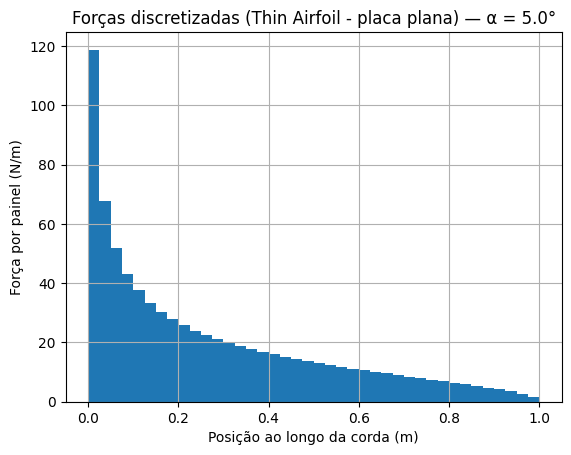

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def delta_cp_flat_plate(x_over_c, alpha_rad):
    """
    Thin Airfoil Theory (flat plate):
    ΔCp(x) = Cp_lower - Cp_upper = 4 α sqrt((1 - x/c)/(x/c))
    alpha em radianos
    """
    return 4.0 * alpha_rad * np.sqrt((1.0 - x_over_c) / x_over_c)

def discretize_forces(N, alpha_deg, c=1.0, rho=1.225, V_inf=50.0):
    """
    Discretiza a distribuição em N forças concentradas (por unidade de envergadura).

    Retorna:
      x_centers : posições (m) onde as forças são aplicadas (centro de cada painel)
      forces    : forças por painel (N/m)
      total_lift: soma total das forças (N/m)
    """
    alpha = np.deg2rad(alpha_deg)

    # evita singularidades exatamente em x=0 e x=c
    eps = 1e-6
    x_edges = np.linspace(eps, c - eps, N + 1)
    dx = np.diff(x_edges)

    # centros dos painéis
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    x_over_c = x_centers / c

    # ΔCp nos centros
    dcp = delta_cp_flat_plate(x_over_c, alpha)

    # pressão dinâmica
    q_inf = 0.5 * rho * V_inf**2

    # força em cada painel (por unidade de envergadura)
    forces = q_inf * dcp * dx
    total_lift = np.sum(forces)

    return x_centers, forces, total_lift

if __name__ == "__main__":
    # -------- parâmetros --------
    N = 40           # número de painéis (forças)
    alpha_deg = 5.0  # ângulo de ataque (graus)
    c = 1.0          # corda (m)
    rho = 1.225      # densidade (kg/m³)
    V_inf = 50.0     # velocidade (m/s)

    x, F, L_total = discretize_forces(N, alpha_deg, c, rho, V_inf)

    print("Posições x (m):")
    print(x)
    print("\nForças por painel (N/m):")
    print(F)
    print("\nSustentação total discretizada (N/m):", L_total)

    # -------- gráfico de barras --------
    plt.figure()
    plt.bar(x, F, width=c/N)
    plt.xlabel("Posição ao longo da corda (m)")
    plt.ylabel("Força por painel (N/m)")
    plt.title(f"Forças discretizadas (Thin Airfoil - placa plana) — α = {alpha_deg:.1f}°")
    plt.grid(True)
    plt.show()

In [19]:
def centro_trapezoidal(x0, x1, D0, D1):
    """
    Retorna (x_barra, F) onde:
      - x_barra é o centro de aplicação ao longo de x
      - F é a força resultante (área sob D(x))
    D0 e D1 são as alturas em x0 e x1 (variação linear).
    """
    L = x1 - x0
    if L == 0:
        raise ValueError("x0 e x1 não podem ser iguais (comprimento L=0).")

    denom = D0 + D1
    if denom == 0:
        raise ValueError("D0 + D1 = 0 -> área/resultante nula; centro indefinido.")

    F = 0.5 * denom * L
    x_bar = x0 + L * (D0 + 2*D1) / (3 * denom)
    return x_bar, F

In [102]:

# ----- parâmetros da asa -----
b = .55       # meia-envergadura
c_root = 0.4    # corda na raiz
c_tip = 0.25    # corda na ponta
# x, _, _ = discretize_forces(N, alpha_deg, c, rho, V_inf)

nx = 24          # divisões na corda
ny = 24        # divisões na envergadura
x, _, _ = discretize_forces(nx, alpha_deg, c, rho, V_inf)
#nesse caso aqui x e a porcentagem da corda do perfil onde a força sera applicada 

x = np.insert(x, 0, 0)   # add 0 no inicio (bordo de ataque)
x = np.append(x, 1)         # adiciona 1 no final (bordo de fuga)
x = 1 -x #inverter pq o meu x inicia no bordo de fuga 
x = x[::-1] # inverter a ordem do array para processamento 


#primeira malha
y = np.array([ (b/ny)*i for i in range(ny+1)] ) #primeira dis
#calcular a corda em função de x
c_y = ((c_tip - c_root)/b)*y + c_root


#segunda discretização 

y_2 = np.array([centro_trapezoidal(y[i], y[i+1], c_y[i], c_y[i+1])[0] for i in range(len(y) -1)  ] )
y_2 = np.insert(y_2, 0, 0)   # add 0 no inicio (bordo de ataque)
y_2 = np.append(y_2, b)         # adiciona 1 no final (bordo de fuga)

c_y2 = ((c_tip - c_root)/b)*y_2 + c_root

# Discretização aerodinamica 
nodes2 = []
for j in range(len(y_2)):
    dc_y = c_y2[j]*x 
    for i in range(len(x)):
        nodes2.append([dc_y[i],y_2[j] ,0])
        
nodes2 = np.array(nodes2)
        
        
quads2 = []
ayy =len(y_2)
axx = len(x)
for j in range(ayy -1): 
    for i in range(axx-1):
        quads2.append([(i + axx*j),(i+1 + axx*j ),(i+1 + axx*(j+1)), (i + axx*(j+1))])
        
quads2 = np.array(quads2)


In [50]:
len(y_2)

26

Número de nós: 625
Número de elementos (quads): 576


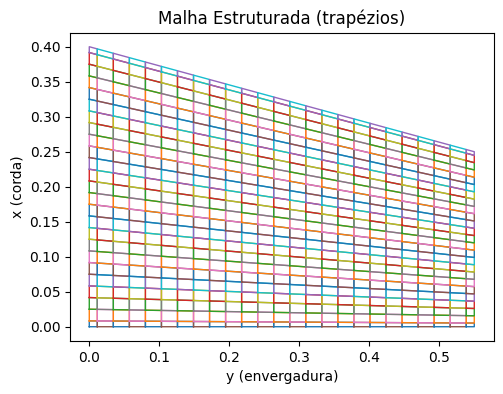

In [108]:

# ============================================================
# Plot 2D (mesma convenção que você usava)
# ============================================================

def plot_mesh_2d_structured(nodes, quads, title="Malha Estruturada (trapézios)"):

    plt.figure(figsize=(9,4))

    for q in quads:
        P = nodes[q][:, :2]
        P = np.vstack([P, P[0]])
        plt.plot(P[:,1], P[:,0], linewidth=1)  # y vira x, x vira y

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("y (envergadura)")
    plt.ylabel("x (corda)")
    plt.title(title)
    plt.show()


# ----- plotar -----
print("Número de nós:", len(nodes))
print("Número de elementos (quads):", len(quads))
plot_mesh_2d_structured(nodes2, quads2)

In [99]:
nodes[quads[0]]

array([[0.        , 0.        , 0.        ],
       [0.01666667, 0.        , 0.        ],
       [0.01640625, 0.02291667, 0.        ],
       [0.        , 0.02291667, 0.        ]])

In [101]:
nodes2[quads2[0]]

array([[0.        , 0.        , 0.        ],
       [0.00833372, 0.        , 0.        ],
       [0.        , 0.01142826, 0.        ],
       [0.00826878, 0.01142826, 0.        ]])